## Прикладная статистика в машинном обучении

### Домашнее задание \#2: EM-алгоритм. Линейная регрессия.

- Домашнее задание оценивается в 10 баллов.


- Решения принимаются до **1 декабря 2020 года**, 23:59 МСК включительно.
Работы, отправленные после дедлайна, оцениваются следующим образом:
    - До 7:00 МСК 2 октября: максимум 8 баллов.
    - До 23:59 МСК 2 октября: максимум 7 баллов.
    - До 23:59 МСК 3 октября: максимум 6 баллов.
    
    
- Работы, отправленные после 3-го октября, будут проверены без оценки.


- Все решения нужно загрузить в личный репозиторий на [GitHub Classroom](https://classroom.github.com/a/AGkPGEn3).


- Репозиторий должен содержать: один .ipynb-файл с решениями задач, который должен иметь название `name_surname_hw2.pdf`


- Весь код должен быть написан на Python.


- Разрешается использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания. 


- Разрешается использовать любые свободные источники с указанием ссылки на них.


- Плагиат не допускается.
При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал. 
---

<img src="https://sun9-4.userapi.com/impf/HG39pXPxpNW1p9PJz9zMQlxTb7VZgr3E-16Nsg/LdZ6ceGYX_o.jpg?size=533x366&quality=96&proxy=1&sign=f535fd36870bd41a094ab17d0c994824">

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import random
from sklearn.metrics import r2_score
sns.set(style="darkgrid")

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore") 

### Задача 1: "Separe!" (5 баллов).

В этой задаче мы снова будем помогать Гарри и Гермионе, но уже не из оригинального цикла, а из "Методов рационального мышления". Гарри и Гермиона хотят изучить свойства практической реализации EM-алгоритма для разделения смеси нормальных распределений.

**Пункт 1.** Напишите функцию `create_mixture(mu, sigma, n)`, которая принимает вектор математических ожиданий `mu` и вектор дисперсий `sigma` длины $k$, генерирует `n` наблюдений из каждого из $k$ нормальных распределений, перемешивает эти $nk$ наблюдений и возвращает вектор, содержащий смесь распределений.

In [3]:
def create_mixture(mu, sigma, n):
    dist_v = []
    k = len(mu)
    
    for i in range(k):
        cur_dist = np.random.normal(mu[i], np.sqrt(sigma[i]), n)
        dist_v.append(cur_dist)

    dist_v = np.array(dist_v).flatten()
    np.random.shuffle(dist_v)

    return dist_v

**Пункт 2.** Протестируйте написанную функцию для случая $k = 3$, самостоятельно выбрав параметры соответствующих нормальных распределений и число наблюдений. Постройте две картинки: на одной изобразите три гистограммы, по одной для каждого из распределений, а на вторую поместите гистограмму полученной смеси.

In [55]:
mu = [9, 5, 1]
sigma2 = [2, 0.5, 4]
n = 1000

y_1 = np.random.normal(mu[0], np.sqrt(sigma2[0]), n)
y_2 = np.random.normal(mu[1], np.sqrt(sigma2[1]), n)
y_3 = np.random.normal(mu[2], np.sqrt(sigma2[2]), n)

np.random.seed(100)
mixture = create_mixture(mu, sigma2, n)

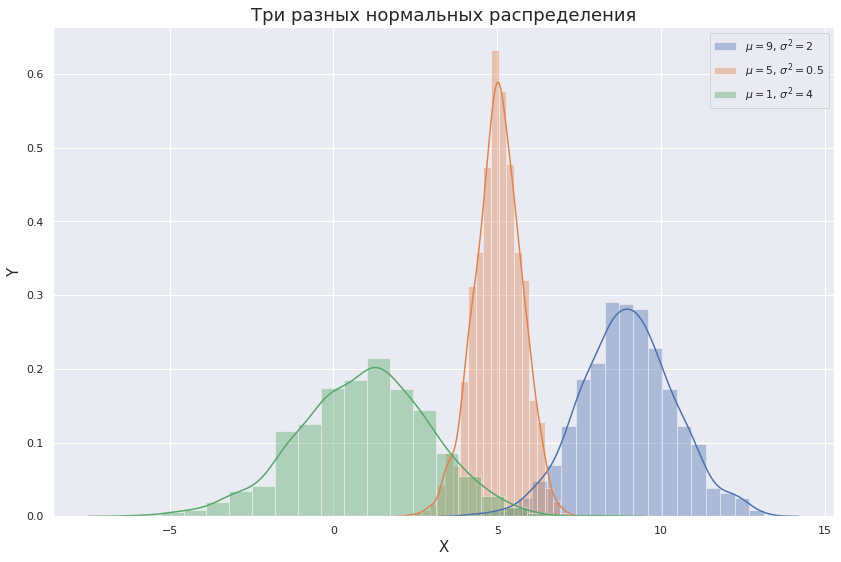

In [56]:
plt.figure(figsize=(14, 9))

sns.distplot(y_1, bins=20, label=r'$\mu = 9$, $\sigma^2 = 2$')
sns.distplot(y_2, bins=20, label=r'$\mu = 5$, $\sigma^2 = 0.5$')
sns.distplot(y_3, bins=20, label=r'$\mu = 1$, $\sigma^2 = 4$')

plt.xlabel('X', size=15)
plt.ylabel('Y', size=15)
plt.title('Три разных нормальных распределения', size=18)

plt.legend()
plt.show()

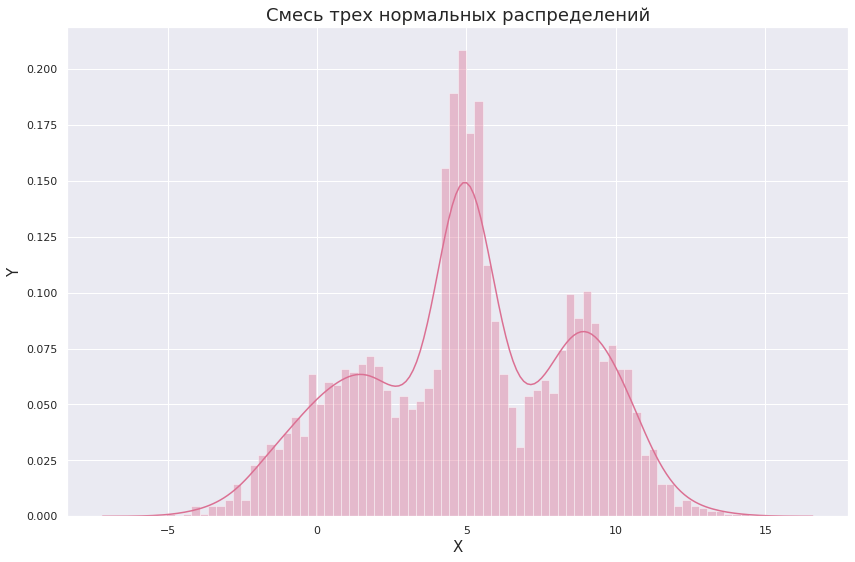

In [57]:
plt.figure(figsize=(14, 9))
sns.distplot(mixture, bins=70, color='palevioletred')
 
plt.xlabel('X', size=15)
plt.ylabel('Y', size=15)
plt.title('Смесь трех нормальных распределений', size=18)

plt.show()

**Пункт 3.** Гермиона помнит формулы шагов EM-алгоритма только для случая $k = 2$, что ограничивает проведение исследования. Выведите формулы шагов EM-алгоритма для разделения смеси $k$ нормальных распределений. Запишите основные шаги вывода формул и финальный результат в ячейке Markdown ниже.

Общий вид:

>  **Инициализация:** задать начальные условия на $\theta_{old}$.

> **E.1-шаг:** найти условное распределение латентных переменных $p(Z | X, \theta_{old})$.

> **E.2-шаг:** построить функцию $Q(\theta, \theta_{old}) = E_{Z | X, \theta}(\ell(x, z | \theta) | x, \theta_{old})$.

> **M-шаг:** максимизировать $Q$ по $\theta$.

> Далее повторять E- и M-шаги до сходимости.

В нашем случае:
$z = \{1, 2, ..., k\}$ - номер кластера.

**Инициализация:**

$$\theta = (\mu_1,\sigma^2_1, ... , \mu_k, \sigma^2_k, p_1, ..., p_{k-1})$$

**E.1:**

По формуле условной вероятности:
$$
p(z | x, \theta_{old}) = \dfrac{p(z, x | \theta_{old})}{p(x | \theta_{old})}
$$
и
$$
p(x | z, \theta_{old}) = \dfrac{p(x, z | \theta_{old})}{p(z)}
$$
Тогда
$$
P(z_i = 1 | x_i, \theta_{old}) = \dfrac{p(z_i = 1, x_i | \theta_{old})}{f(x_i | \theta_{old})}
 = \dfrac{f(x_i | z_i = 1, \theta_{old})p_1}{p_1f(x_i | z_i = 1, \theta_{old}) + ... + p_{k-1}f(x_i | z_i = k - 1, \theta_{old}) + (1 - p_1 - ... - p_{k-1})f(x_i | z_i = k, \theta_{old})}$$
 $$\vdots$$
$$P(z_i = k - 1 | x_i, \theta_{old})  = \dfrac{f(x_i | z_i = k - 1, \theta_{old})p_{k-1}}{p_1f(x_i | z_i = 1, \theta_{old}) + ... + p_{k-1}f(x_i | z_i = k - 1, \theta_{old}) + (1 - p_1 - ... - p_{k-1})f(x_i | z_i = k, \theta_{old})}$$

$$P(z_i = k | x_i, \theta_{old})  = 1 - P(z_i = 1 | x_i, \theta_{old}) - ... - P(z_i = k - 1 | x_i, \theta_{old}) $$


**E.2:**

Построим функцию $Q(\theta, \theta_{old}) = E_{Z | X, \theta}(\ell(x, z | \theta) | x, \theta_{old})$.

По формуле условной вероятности:
$$
p(x, z | \theta) = p(x | \theta, z) \cdot p(z)
$$

$$
Q(\theta, \theta_{old}) = \sum_i P(z_i = 1 | x, \theta_{old})[\ln f(x_i | \theta) + \ln p_1] + ... + P(z_i = k - 1 | x, \theta_{old})[\ln f(x_i | \theta) + \ln p_{k-1}] + (1 - P(z_i = 1 | x, \theta_{old}) - ... -  P(z_i = k - 1| x, \theta_{old}) )[\ln f(x_i | \theta) + \ln(1-p_1- ... - p_{k-1})].
$$

**M:**

Теперь будем максимизировать $Q$ по всем переменным, то есть искать производную по переменной и приравнивать к нулю.
$$
Q'_{\mu_1} = \sum_i P(z_i = 1 | x, \theta_{old}) \dfrac{(x_i - \mu_1)}{\sigma_1^2}
$$

$$
\mu_1^{new} = \dfrac{\sum_i P(z_i = 1 | x, \theta_{old}) x_i}{\sum_i P(z_i = 1 | x, \theta_{old})}
$$

$$
\mu_j^{new} = \dfrac{\sum_i (1 - P(z_i = j | x, \theta_{old})) x_i}{\sum_i (1 - P(z_i = j | x, \theta_{old}))}
$$

$$
Q'_{\sigma_1^2} = \sum_i P(z_i = 1 | x, \theta_{old}) (-\dfrac{1}{2\sigma^2_1} + \dfrac{1}{2}\dfrac{(x_i - \mu_1)^2}{\sigma_1^4})
$$

$$
\sigma_1^{2, new} = \dfrac{\sum_i (x_i - \mu)^2 P(z_i = 1 | x, \theta_{old})}{\sum_i P(z_i = 1 | x, \theta_{old})}
$$

$$
\sigma_j^{2, new} = \dfrac{\sum_i (x_i - \mu)^2 P(z_i = j | x, \theta_{old})}{\sum_i P(z_i = j | x, \theta_{old})}
$$

$$
Q'_{p_1} = \sum_i P(z_i = 1 | x, \theta_{old}) \dfrac{1}{p_1} - (1 - P(z_i = 1 | x, \theta_{old})) \dfrac{1}{1 - p_1}
$$

$$
p_1^{new} = \dfrac{\sum_i P(z_i = 1 | x, \theta_{old})}{n}
$$

$$
p_j^{new} = \dfrac{\sum_i P(z_i = j | x, \theta_{old})}{n}
$$

**Пункт 4.** Реализуйте EM-алгоритм для разделения смеси нормальных распределений в виде функции `EM(mixture, k, theta)`. На вход эта функция принимает вектор `x`, содержащий смесь нормальных распределений, число предполагаемых кластеров `k` и вектор изначальных предположений о параметрах распределений и вероятностях принадлежности к соответствующим кластерам `theta`. Функция должна возвращать кортеж `(theta_new, Q_history)`, содержащий вектор параметров `theta_new`, полученный после работы EM-алгоритма, и историю обновлений функции M-шага $Q$.

In [11]:
def f(x, mu, sigma2):
    return 1 / np.sqrt(2 * np.pi * sigma2) * np.exp(-1/2 * 1/sigma2 * (x - mu)**2)

In [12]:
def lnf(x, mu, sigma2):
    return -1/2 * np.log(2 * np.pi * sigma2) - 1/2 * (x - mu) ** 2 / sigma2

In [13]:
def Q_f(x, theta, p, k, p_k):
    q = []

    for i in range(k-1):
        q.append(p[i] * (lnf(x, theta[2*i], theta[2*i + 1]) + np.log(theta[2*k + i])))

    q.append(p_k * (lnf(x, theta[2*k - 2], theta[2*k - 1]) + np.log(1 - np.sum(theta[2*k:]))))
    res = np.sum(q)
    return res

In [59]:
def EM(mixture, k, theta):
    #theta = (mu_1, sigma2_1, mu_2, sigma2_2, ..., mu_k, sigma2_k, p_1, ..., p_{k-1})
    Q_history = []
    
    for i in range(200):
        sum = 0
        for j in range(k-1):  #считаем знаметатель дроби
            sum += (theta[2*k + j] * f(mixture, theta[2*j], theta[2*j + 1]))
        sum += ((1 - np.sum(theta[2*k:])) * f(mixture, theta[2*k - 2], theta[2*k - 1]))
        
        # E-step
        p = []
        for j in range(k-1):
            p.append(f(mixture, theta[2*j], theta[2*j + 1]) * theta[2*k + j] / sum)
        p_k = 1 - np.sum(p, axis=0)
    
        Q_history.append(Q_f(mixture, theta, p, k, p_k))
        
        if i > 0:
            if (Q_history[i] - Q_history[i-1])**2 < 1e-4:
                break
        # M-step
        mu = []
        sigma2 = []
        p_res = []
        for j in range(k-1):
            mu.append(np.sum(p[j] * mixture) / np.sum(p[j]))
            sigma2.append(np.sum((mixture - mu[j]) ** 2 * p[j])/ np.sum(p[j]))
            p_res.append(np.sum(p[j]) / len(mixture))

        mu.append(np.sum(p_k * mixture) / np.sum(p_k))
        sigma2.append(np.sum((mixture - mu[k-1]) ** 2 * p_k)/ np.sum(p_k))

        theta_new = []
        for j in range(k):
            theta_new.append(mu[j])
            theta_new.append(sigma2[j])
        for j in range(k-1):
            theta_new.append(p_res[j])

        theta = theta_new
        """
        Q_history.append(Q_f(mixture, theta, p, k, p_k))

        if i > 0:
            if (Q_history[i] - Q_history[i-1])**2 < 1e-4:
                break
        """
    
    return (theta, Q_history)

**Пункт 5.** Используйте сгенерированную в Пункте 2 смесь, чтобы протестировать работу EM-алгоритма. Задайте вектор `theta` каким-нибудь разумным образом, но так, чтобы изначальные параметры не совпадали с истинными, которые вы использовали для генерации смеси (Гарри считает это нарушением чистоты эксперимента). Параметр `k` укажите равным 3.

In [60]:
k = 3
th_cor = (9, 2, 5, 0.5, 1, 4, 1/3, 1/3) #это истинное theta, просто чтобы было
th = (7, 5, 3, 6, 2, 4, 1/4, 1/2)  #будем считать, что это раумный способ, тут еще пока не просили формулами

theta, Q = EM(mixture, k, th)

In [61]:
theta

[8.903717954692931,
 2.354281681646541,
 4.993673628589027,
 0.44210016619250686,
 1.1894889958154629,
 4.026550301841621,
 0.3419670989362398,
 0.3196096216956206]

Выглядит неплохо.

**Пункт 6.** Гермиона утверждает, что с теортической точки зрения функция $Q$ должна монотонно возрастать: на каждой итерации EM-алгоритма мы увеличиваем значение правдоподобия. "What do you think you know and how do you think you know it?" - отвечает Гарри и задаёт три своих вопроса:
1. О каком правдоподобии идёт речь: $p(X|\theta)$ или $p(X, Z | \theta)$?
2. Увеличивается или не уменьшается? 
3. Почему это утвержедение верно? 

Помогите Гермионе ответить на вопросы Гарри. Запишите ответы в ячейке Markdown ниже.

*Подсказка:* соответствующая цепочка неравенств была на одной из лекций.

На лекции было такое утверждение:

$$\ell(X |\theta_{old}) = [E-step] = LB(q^{new}, \theta_{old}) \leq LB(q^{new}, \theta_{new}) \leq [M-step] \leq \ell(X | \theta_{new}) $$
$$\Rightarrow  \ell(X | \theta_{new}) \geq \ell(X |\theta_{old}) \Rightarrow p(X | \theta_{new}) \geq p(X |\theta_{old})$$

Таким образом можем ответить на вопросы Гарри:

1. Речь идет о правдоподобии $p(X | \theta)$
2. Правдоподобие не уменьшается (знак $\geq$ в неравенстве)
3. Это утверждение верно из цепочки неравенств выше (было доказано на лекции). Каждый переход обусловлен одним из шагов $EM$ алгоритма.

**Пункт 7.** Разобравшись с предыдущим вопросом, Гермиона вспомнила, что она недавно [прочитала](https://stats.stackexchange.com/questions/341173/em-algorithm-seems-to-work-but-q-is-not-monotonic-possible-reasons), что при практической реализации EM-алгоритма динамика $Q$ зависит от того, на каком шаге обновляется история изменения $Q$. Постройте два графика с динамикой $Q$, подтверждающие слова Гермионы, и объясните, используя материалы по ссылке, почему Гермиона права. Используйте те же параметры, что и в Пункте 5.

1. Обновляем  $Q$ перед обновление $\theta$:


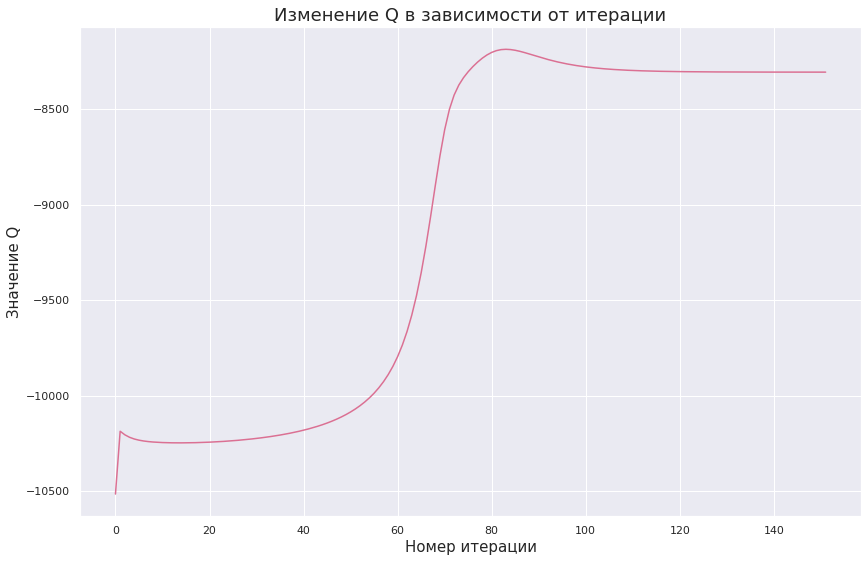

In [62]:
plt.figure(figsize=(14, 9))
plt.plot(Q, color='palevioletred')
 
plt.xlabel('Номер итерации', size=15)
plt.ylabel('Значение Q', size=15)
plt.title('Изменение Q в зависимости от итерации', size=18)

plt.show()

2. Обновлем $Q$ после обновления $\theta$:

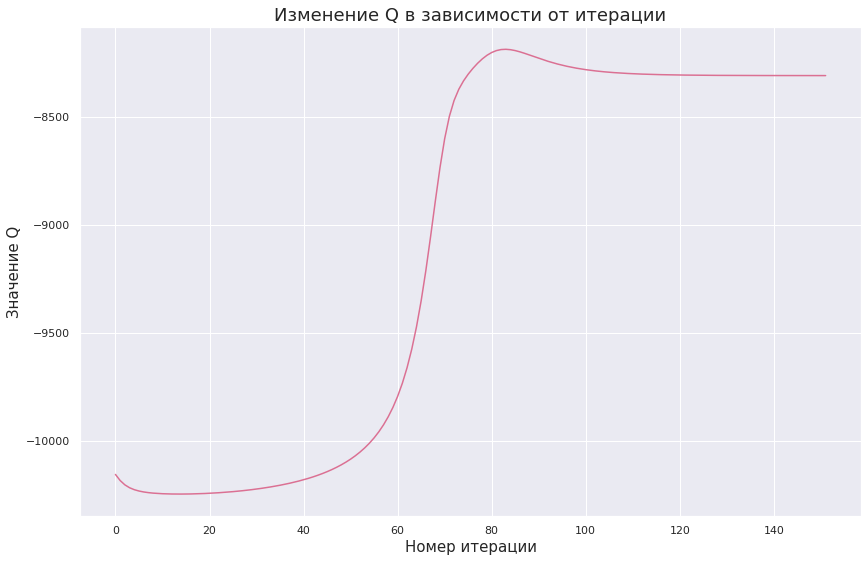

In [58]:
k = 3
th = (7, 5, 3, 6, 2, 4, 1/4, 1/2)
theta_new, Q_new = EM(mixture, k, th)

plt.figure(figsize=(14, 9))
plt.plot(Q_new, color='palevioletred')
 
plt.xlabel('Номер итерации', size=15)
plt.ylabel('Значение Q', size=15)
plt.title('Изменение Q в зависимости от итерации', size=18)

plt.show()

Как можно заметить, разницы почти нет, только график немного сместился вправо (что логично). А это я еще очень пыталась подобрать график, на котором хоть как-то будут видны изменения. Очевидно, что мы просто не учитываем первое значение Q, то есть на начальном theta. И если там происходили какие-то резкие изменения на первом шаге, то они, конечно, отражены не будут, если добавлять Q после обновления theta. В остальном разницы, очевидно, нет.


**Пункт 8.** Гарри хочет экспериментально проверить поведение EM-алгоритма при различных комбинациях параметров. Выберите какой-нибудь количественный способ оценить качество работы EM-алгоритма (подойдёт любое разумное обоснованное решение) и оцените качество работы для сетки параметров $k = (2, 5, 10)$, $n = (10, 100, 1000)$.
Для этого:
1. Сгенерируйте смесь распределений с нужным числом $k$ и $n$.
2. Запустите функцию `EM(...)` на этой смеси. Параметр `k` укажите равным тестируемому значению (то есть 2, 5 или 10). 

Вектор начальных параметров `theta` для каждого случая генерируйте на основе какой-либо разумной статистики (например, для дисперсий можно взять разность крайних значений вариационного ряда, делённую на два). Постройте графики зависимости качества работы EM-алгоритма от используемых параметров `n` и `k` (то есть всего 9 графиков) и прокомментируйте наблюдаемые зависимости.

Что ж, ну раз для измерения качества EM-а подойдет любое разумное решение, то будем считать MSE. То есть рассмотрим изначальный вектор theta и найдем сумму квадратов разностей с theta, который выдал EM. Соответсвенно, чем меньше MSE, тем лучше. MSE - функционал, который используется в огромном множестве задач машинного обучения и анализа данных, поэтому поиспользуем его и тут. Можно бы было еще MAE, который больше усточив к выбросам. Но в данном случае это особо не требуется. Использовать какой-нибудь MAPE смымсла тут нет, RMSE тоже. Так что остановимся на MSE.

In [63]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

Я не знаю, как посчитать качество EM-а на каждой итерации без модификации самой функции, так что сори...

In [64]:
def EM_err(mixture, k, theta, theta_old):
    Q_history = []
    err = []
    
    for i in range(300):
        sum = 0
        for j in range(k-1):  #считаем знаметатель дроби
            sum += (theta[2*k + j] * f(mixture, theta[2*j], theta[2*j + 1]))
        sum += ((1 - np.sum(theta[2*k:])) * f(mixture, theta[2*k - 2], theta[2*k - 1]))
        
        # E-step
        p = []
        for j in range(k-1):
            p.append(f(mixture, theta[2*j], theta[2*j + 1]) * theta[2*k + j] / sum)
        p_k = 1 - np.sum(p, axis=0)
        
        Q_history.append(Q_f(mixture, theta, p, k, p_k))

        if i > 0:
            if (Q_history[i] - Q_history[i-1])**2 < 1e-4:
                break

        # M-step
        mu = []
        sigma2 = []
        p_res = []
        for j in range(k-1):
            mu.append(np.sum(p[j] * mixture) / np.sum(p[j]))
            sigma2.append(np.sum((mixture - mu[j]) ** 2 * p[j])/ np.sum(p[j]))
            p_res.append(np.sum(p[j]) / len(mixture))

        mu.append(np.sum(p_k * mixture) / np.sum(p_k))
        sigma2.append(np.sum((mixture - mu[k-1]) ** 2 * p_k)/ np.sum(p_k))

        theta_new = []
        for j in range(k):
            theta_new.append(mu[j])
            theta_new.append(sigma2[j])
        for j in range(k-1):
            theta_new.append(p_res[j])

        theta = theta_new
        err.append(MSE(theta_old, theta))

    
    return (theta, Q_history, err)

In [65]:
k_s = [2, 5, 10]
n_s = [10, 100, 1000]

theta = []
Q = []
mse = []
x_es = []

for k in k_s:
    for n in n_s:
        x_es.append((k, n)) #это для графика, ничего не спрашивайте...
        #k - длина mu, sigma
        #mu = range(0, k)
        #sigma2 = range(1, k + 1)
        mu = np.random.randint(0, 15, k)
        sigma2 = np.random.randint(1, 15, k)

        theta_old = []
        for i in range(k):
            theta_old.append(mu[i])
            theta_old.append(sigma2[i])

        for i in range(k - 1):
            theta_old.append(1/k)

        mixture = create_mixture(mu, sigma2, n)
        theta_start = []
        for i in range(k):
            theta_start.append(np.min(mixture) + i/k *(np.max(mixture) - np.min(mixture)))  #mu
            theta_start.append((np.max(mixture) - np.min(mixture)) / 2)  #sigma^2

        for i in range(k - 1):
            theta_start.append(1/k)

        res_th, res_q, mse_cur = EM_err(mixture, k, theta_start, theta_old)
        theta.append(res_th)
        Q.append(res_q)
        mse.append(mse_cur)

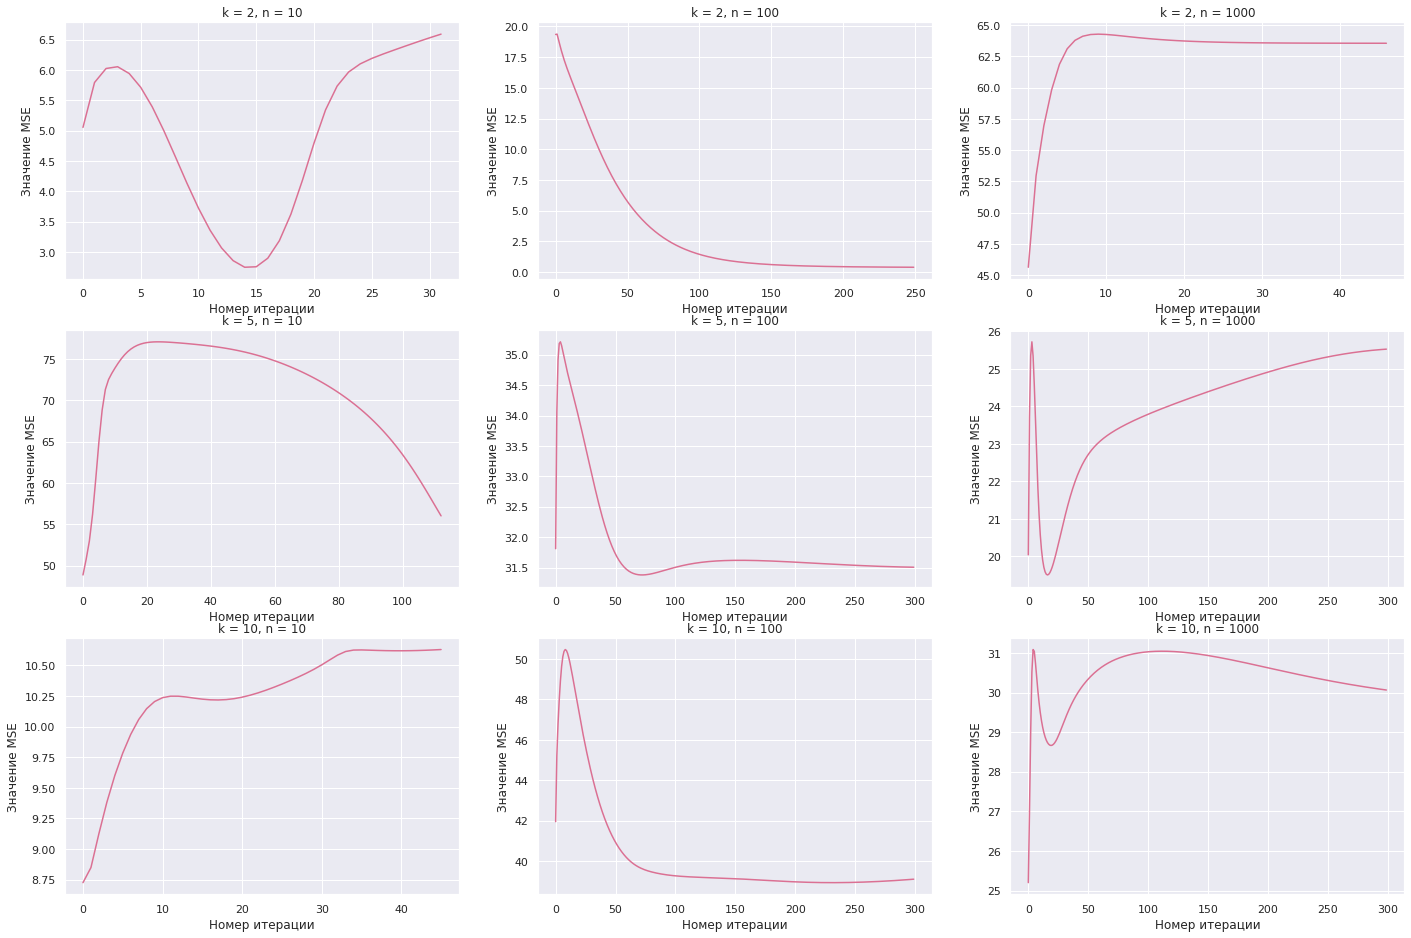

In [66]:
total_axes = 9 
plt.figure(figsize=(24, 50))

sp = 1  
for k in k_s:
    for n in n_s:
         plt.subplot(total_axes, 3, sp, title='k = %d, n = %d' % (k, n), xlabel='Номер итерации', ylabel='Значение MSE')
         plt.plot(mse[sp-1], color='palevioletred')
         sp += 1


Мы можем заметить некоторые общие тенденции в графиках качества

Во-первых, заметим, что при любых значениях параметров качество сначала растет (где-то более резко, где-то менее резеко, да, при k=2, n=10 оно на первом шаге тоже растет...)
А в остальном паттерны отличаются в зависимости от значений параметров. Можно заметить, что чем больше k и n тем менее плавынм выглядит график качества (оно сначала растет, потом падает, потом опять растет). Если смотреть на изменение n или k при другом фиксированном параметре, то я бы не сказала, что тут повсюду наблюдается общая закономерность. 

При большом количестве объектов в кластере и при больше качество то падает, то растет и т.д.

Также можно заметить, что при n = 100 (количество объектов в каждом кластере) качество работы EM алгоритма под конце падает. Что значит, что алгоритм не очень хорошо справился с задачей разделения смеси

**Пункт 9.** После перебора разных значений `k` Гермионе стало интересно, что произойдёт, если поставить предполагаемое значение числа кластеров больше или меньше истинного. Проведите два эксперимента: выберите какое-нибудь небольшое значение $k$ и запустите EM-алгоритм с `k`, меньшим истинного, и `k`, большим истинного. Поясните полученные результаты.

Ну пусть k = 3, запустим EM с k = 2 и k = 4. Возьмем смесь из первого номера.

In [69]:
mu = [9, 5, 1]
sigma2 = [2, 0.5, 4]

theta_cor = [9, 2, 5, 0.5, 1, 4, 1/3, 1/3]
n = 1000

y_1 = np.random.normal(mu[0], np.sqrt(sigma2[0]), n)
y_2 = np.random.normal(mu[1], np.sqrt(sigma2[1]), n)
y_3 = np.random.normal(mu[2], np.sqrt(sigma2[2]), n)

mixture = create_mixture(mu, sigma2, n)

In [70]:
th_2 = (np.min(mixture), (np.max(mixture) - np.min(mixture)) / 2,
        np.min(mixture) + 1/k *(np.max(mixture) - np.min(mixture)), (np.max(mixture) - np.min(mixture)) / 2, 1/2)
th_4 = (np.min(mixture), (np.max(mixture) - np.min(mixture)) / 2,
        np.min(mixture) + 1/k *(np.max(mixture) - np.min(mixture)), (np.max(mixture) - np.min(mixture)) / 2,
        np.min(mixture) + 2/k *(np.max(mixture) - np.min(mixture)), (np.max(mixture) - np.min(mixture)) / 2,
        np.min(mixture) + 3/k *(np.max(mixture) - np.min(mixture)), (np.max(mixture) - np.min(mixture)) / 2, 1/4, 1/4, 1/4)

theta_2, Q_2 = EM(mixture, 2, th_2)
theta_4, Q_4 = EM(mixture, 4, th_4)

In [72]:
print('Theta для k на 1 меньше истинного (= 2):')
print(theta_2)
print()
print('Theta для k на 1 больше истинного (= 4):')
print(theta_4)
print()
print('Истинное значение theta:')
print(theta_cor)

Theta для k на 1 меньше истинного (= 2):
[-0.19368130549616014, 2.2761083264707205, 6.059776964542602, 8.121025186297885, 0.16856934466672147]

Theta для k на 1 больше истинного (= 4):
[1.92014719794937, 5.049377946029173, 0.07709120796091021, 2.7935369259113187, 5.053414606703502, 0.4835423693083534, 9.007840442593968, 1.9249035153254608, 0.23658211755344558, 0.11813471817139036, 0.3212481085680602]

Истинное значение theta:
[9, 2, 5, 0.5, 1, 4, 0.3333333333333333, 0.3333333333333333]


Ну что сказать, ну что сказать... Я не знаю, что тут должно было получиться. Но как мне кажется, ничего хорошего. У нас же в EM есть очень много действий, зависящих от количества кластеров. И в данном случае это просто все сбивается. И при этом все считается для текущей смеси и разного количества кластеров. Таким образом все сбвивается уже на Е шаге. А значит EM алгоритм не будет работать корректно, что мы и видим. Причем не только оценку параметров распределения, но и оценку вероятностей кластера 

### Задача 2: "Cloudy, with a chance of..." (5 баллов).

В этой задаче нам предстоит проанализировать набор данных [Weather in Szeged 2006-2016](https://www.kaggle.com/budincsevity/szeged-weather), содержащий информацию о погоде. Формат задачи свободный: оцениваются любые разумные действия. В качестве зависимой переменной возьмём температуру воздуха (`temperature`).

Наша цель состоит в том, чтобы построить две линейные регрессионные модели: объясняющую и предиктивную. Объясняющая модель должна быть пригодна для статистической интерпретации зависимостей, то есть показывать, какие факторы влияют на температуру воздуха, каким образом и какое возможное объяснение этого влияния можно привести. Предиктивная модель может быть совершенно ужасной с точки зрения статистики (например, регрессия может быть не значимой в целом), но она должна давать хорошие прогнозы в соответствии с некоторой метрикой.

Хотя приведённые данные имеют формат временных рядов, мы будем игнорировать это и рассматривать их как обычные кросс-секционные данные.

**Предобработка данных**. Загрузите данные и проведите любую предобработку, которую считаете нужной. Поясните свои действия.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
df = pd.read_csv('/content/gdrive/My Drive/weatherHistory.csv')

In [331]:
df

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
...,...,...,...,...,...,...,...,...,...,...,...,...
96448,2016-09-09 19:00:00.000 +0200,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.
96449,2016-09-09 20:00:00.000 +0200,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.
96450,2016-09-09 21:00:00.000 +0200,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.
96451,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.


In [6]:
from sklearn.preprocessing import LabelEncoder

In [74]:
df['Loud Cover'].unique()

array([0.])

Как мы можем заметить, признак Loud Cover имеет одинаковый значения для всех объектов выборки. То есть является абсолютно бесполезным. Удалим этот столбец.

In [7]:
df = df.drop(columns='Loud Cover')

Посмотрим как вообще обстоят дела с пропусками в данных.

In [76]:
df.isnull().sum()

Formatted Date                0
Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64

In [77]:
df['Precip Type'].unique()

array(['rain', 'snow', nan], dtype=object)

Так, ну довольно грустно, надо что-то сделать с Precip Type...

Заполню пропусками просто значениями "no".

In [8]:
df.loc[df['Precip Type'].isnull(), 'Precip Type'] = 'no'

In [79]:
df.isnull().sum()

Formatted Date              0
Summary                     0
Precip Type                 0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Pressure (millibars)        0
Daily Summary               0
dtype: int64

Отлично!

Теперь немного преобразуем дату

In [9]:
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)
df['year'] = df['Formatted Date'].dt.year
df['month'] = df['Formatted Date'].dt.month
df['day'] = df['Formatted Date'].dt.day

Теперь применим label encoder к категориальным признакам, чтобы дальше с ними было удобнее работать

In [10]:
le = LabelEncoder()
df['Summary'] = le.fit_transform(df['Summary'])
le = LabelEncoder()
df['Precip Type'] = le.fit_transform(df['Precip Type'])
le = LabelEncoder()
df['Daily Summary'] = le.fit_transform(df['Daily Summary'])

**Построение объясняющей модели.**

**Пункт 1.** Выберите независимые переменные, которые будут включены в объясняющую модель. Поясните, почему выбор этих переменных разумен (не нужно углубляться в физику поведения жидкостей и ссылаться на уравнения Навье-Стокса, достаточно понятной научно-популярной интерпретации).

Для того, чтобы посмотреть на зависимость признаков, посмотрим на их корреляцию между собой.

In [82]:
df.corr()

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,year,month,day
Summary,1.000000,-0.106454,0.146658,0.142760,-0.113119,0.004258,0.022789,0.140138,0.143405,0.157569,0.055975,-0.030341,-0.016680
Precip Type,-0.106454,1.000000,-0.542245,-0.545264,0.223896,-0.068319,-0.040390,-0.291999,0.006472,-0.235579,-0.065065,-0.151520,0.000498
Temperature (C),0.146658,-0.542245,1.000000,0.992629,-0.632255,0.008957,0.029988,0.392847,-0.005447,0.438879,0.017462,0.148576,-0.000802
Apparent Temperature (C),0.142760,-0.545264,0.992629,1.000000,-0.602571,-0.056650,0.029031,0.381718,-0.000219,0.433791,0.017171,0.157986,0.001743
Humidity,-0.113119,0.223896,-0.632255,-0.602571,1.000000,-0.224951,0.000735,-0.369173,0.005454,-0.368180,0.039257,0.056526,0.004851
Wind Speed (km/h),0.004258,-0.068319,0.008957,-0.056650,-0.224951,1.000000,0.103822,0.100749,-0.049263,-0.004115,-0.004245,-0.098905,-0.006659
Wind Bearing (degrees),0.022789,-0.040390,0.029988,0.029031,0.000735,0.103822,1.000000,0.047594,-0.011651,0.053709,-0.025685,-0.019208,-0.003490
Visibility (km),0.140138,-0.291999,0.392847,0.381718,-0.369173,0.100749,0.047594,1.000000,0.059818,0.457913,0.107306,-0.071946,-0.026374
Pressure (millibars),0.143405,0.006472,-0.005447,-0.000219,0.005454,-0.049263,-0.011651,0.059818,1.000000,0.054305,0.016124,-0.019308,-0.015452
Daily Summary,0.157569,-0.235579,0.438879,0.433791,-0.368180,-0.004115,0.053709,0.457913,0.054305,1.000000,-0.023285,-0.009223,-0.016664


Хочу выбрать признаки "Wind Speed (km/h)", 'Humidity','Visibility'

In [83]:
df[["Wind Speed (km/h)", 'Humidity', 'Visibility (km)']].corr()

,Wind Speed (km/h),Humidity,Visibility (km)
Wind Speed (km/h),1.000000,-0.224951,0.100749
Humidity,-0.224951,1.000000,-0.369173
Visibility (km),0.100749,-0.369173,1.000000


In [84]:
np.linalg.matrix_rank(df[["Wind Speed (km/h)", 'Humidity', 'Visibility (km)']].T)

3

Ранг матрицы 3, значит столбцы линейно независимы, значит эти признаки нам подходят

Как я их выбирала? Ну во-первых по корреляции, то есть смотрела, чтобы они не слишком сильно зависели друг от друга. А во-вторых по тому, как они влияют на таргет исходя из логики. Влажность - исходя из логики, если на улице жарко, то обычно влажность низкая и т.д., скорость ветра - тоже ясно. Чем больше скорость ветра - тем ниже ожидаемая температура. Видимость - если видимость высокая - это скорее всего свидетельствует о том, что на улице ясно и тепло. Низкая видимость обычно при метелях, туманах и т.д. Таким образом низкая видимость обычно свидетельствует о более низкой температуре. Таким образом влияние каждого из трех выбранных мною факторов объяснимо логически.

**Пункт 2.** Изучите зависимости между зависимой и переменной и выбранными вами независимыми переменными. На основе проведённого анализа задайте функциональную форму модели. Например:

$$
\ln y_i = \beta_0 + \beta_1X_{1i} + \beta_2X_{1i}^2 + \beta_3\ln X_{3i} + u_i
$$

Запишите выбранный вид модели в ячейке Markdown ниже и прокомментируйте, почему он разумен (например, почему разумно взять не просто $X_1$, но ещё и его квадрат или взять не просто $y$, а его логарифм).

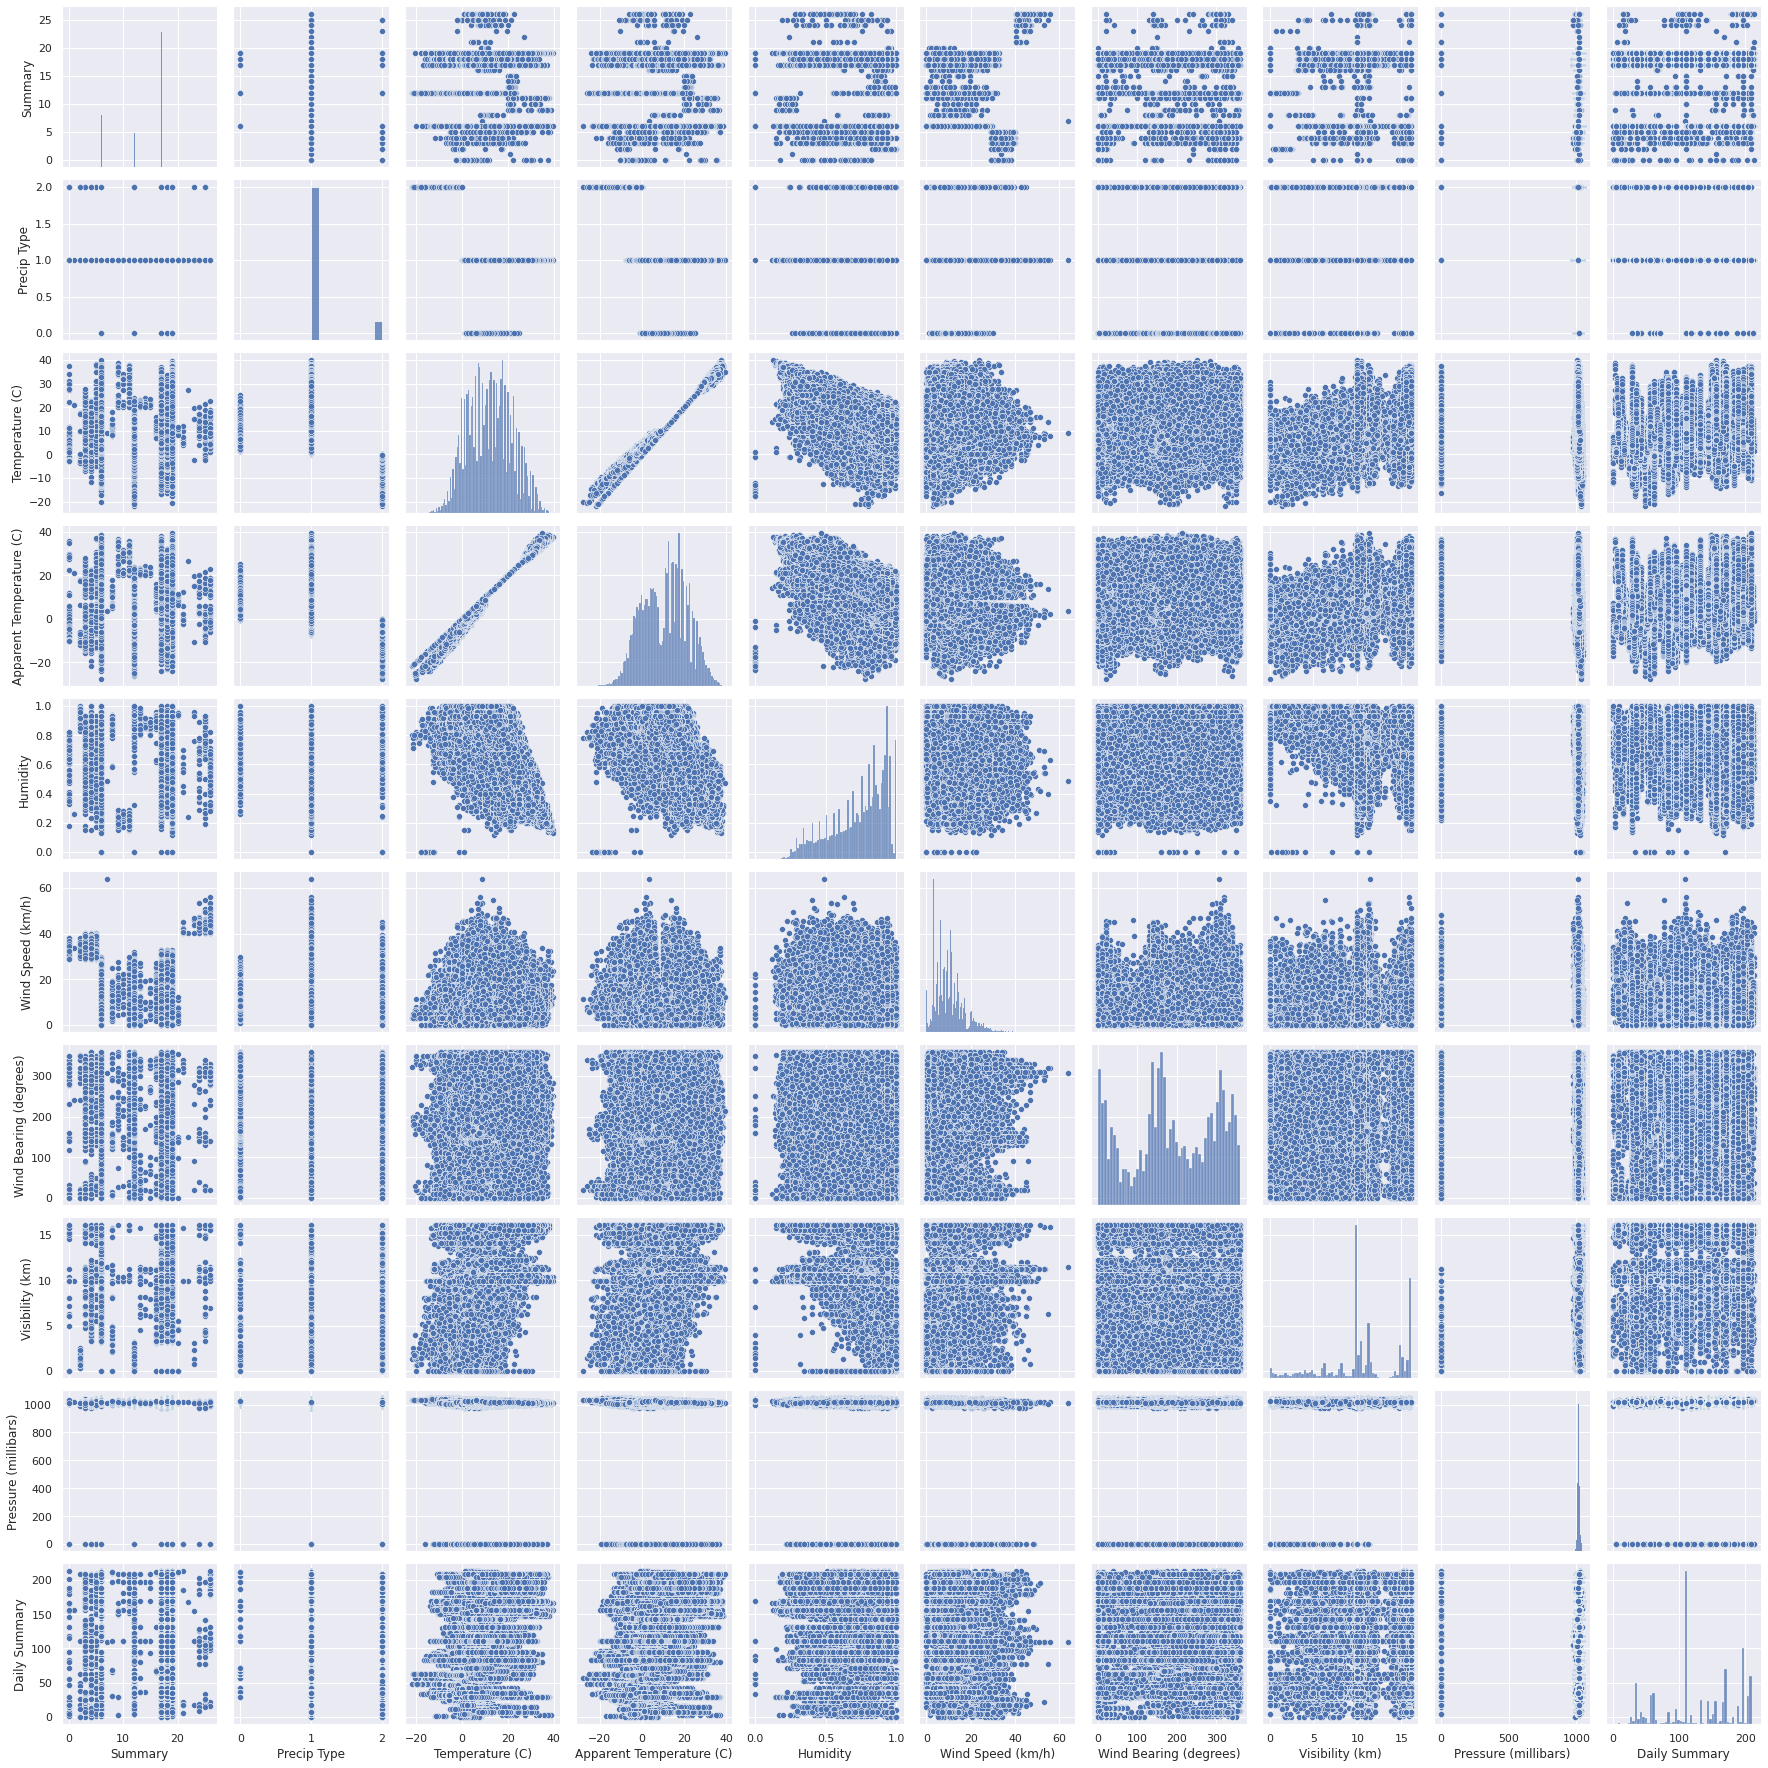

In [ ]:
sns.pairplot(df)

Да, не самые показательные графики в мире...
На графике особо не заметно никакой логарифмической или иной зависимости таргета от признаков, так что рассмотрим корреляцию признаков с таргетом


In [421]:
df[['Temperature (C)', "Wind Speed (km/h)" 'Humidity', 'Visibility (km)']].corr()

,Temperature (C),Wind Speed (km/h),Humidity,Visibility (km)
Temperature (C),1.000000,0.008957,-0.632255,0.392847
Wind Speed (km/h),0.008957,1.000000,-0.224951,0.100749
Humidity,-0.632255,-0.224951,1.000000,-0.369173
Visibility (km),0.392847,0.100749,-0.369173,1.000000


Запомним это. А теперь рассмотрим корреляцию с лоагрифмом таргета

In [12]:
df['log_t'] = np.log(df['Temperature (C)'])

In [424]:
df[['log_t', "Wind Speed (km/h)", 'Humidity', 'Visibility (km)']].corr()

,log_t,Wind Speed (km/h),Humidity,Visibility (km)
log_t,1.000000,-0.029963,-0.475724,0.325942
Wind Speed (km/h),-0.029963,1.000000,-0.224951,0.100749
Humidity,-0.475724,-0.224951,1.000000,-0.369173
Visibility (km),0.325942,0.100749,-0.369173,1.000000


Можем заметить, что корреляция с логарифмом таргета куда меньше, так что будет предсказывать просто таргет

Теперь посмотрим на переменные.

In [11]:
df['w_speed_2'] = df["Wind Speed (km/h)"]**2
df['log_w_speed'] = np.log1p(df["Wind Speed (km/h)"])
df['humidity_2'] = df["Humidity"]**2
df['log_humidity'] = np.log1p(df["Humidity"])
df['vis_2'] = df['Visibility (km)']**2
df['log_vis'] = np.log1p(df['Visibility (km)'])

In [429]:
df[['Temperature (C)', 'log_t', "Wind Speed (km/h)", 'Humidity', 'Visibility (km)', 'w_speed_2', 'log_w_speed', 'humidity_2', 'log_humidity', 'vis_2', 'log_vis']].corr()

,Temperature (C),log_t,Wind Speed (km/h),Humidity,Visibility (km),w_speed_2,log_w_speed,humidity_2,log_humidity,vis_2,log_vis
Temperature (C),1.000000,0.841948,0.008957,-0.632255,0.392847,-0.012053,0.028707,-0.617598,-0.633835,0.324620,0.411523
log_t,0.841948,1.000000,-0.029963,-0.475724,0.325942,-0.033182,-0.023441,-0.473950,-0.473305,0.264252,0.353480
Wind Speed (km/h),0.008957,-0.029963,1.000000,-0.224951,0.100749,0.936325,0.907682,-0.241460,-0.216753,0.050650,0.141105
Humidity,-0.632255,-0.475724,-0.224951,1.000000,-0.369173,-0.187813,-0.224764,0.989105,0.998076,-0.289764,-0.399660
Visibility (km),0.392847,0.325942,0.100749,-0.369173,1.000000,0.079744,0.106640,-0.417818,-0.347470,0.964171,0.933350
w_speed_2,-0.012053,-0.033182,0.936325,-0.187813,0.079744,1.000000,0.728945,-0.202027,-0.180762,0.039167,0.110600
log_w_speed,0.028707,-0.023441,0.907682,-0.224764,0.106640,0.728945,1.000000,-0.240476,-0.216924,0.054489,0.151696
humidity_2,-0.617598,-0.473950,-0.241460,0.989105,-0.417818,-0.202027,-0.240476,1.000000,0.978116,-0.332049,-0.449655
log_humidity,-0.633835,-0.473305,-0.216753,0.998076,-0.347470,-0.180762,-0.216924,0.978116,1.000000,-0.271061,-0.377333
vis_2,0.324620,0.264252,0.050650,-0.289764,0.964171,0.039167,0.054489,-0.332049,-0.271061,1.000000,0.812810


Судя по этой замечательно и очень понятной табличке, мы можем сделать вывод, что лучше прогнозировать сам таргет, а для прогноза использовать логарифм "Wind Speed (km/h)", логарифм "Visibility" и просто "humidity' (там слишком маленькая разница с log)

Итого получим модель следующего вида:

$$y_i = \beta_0 + \beta_1X_{1i} + \beta_2  \ln X_{2i} + \beta_3 \ln X_{3i} + u_i$$

**Пункт 3.** Оцените выбранную модель при помощи МНК. Значима ли регрессия в целом? Если да, переходите к следующему пункту, если нет, то задайте другую функциональную форму модели.

In [13]:
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

Поубираем единицы измерения. они нам мешают построить модель

In [14]:
df.rename(columns={'Temperature (C)' : 'Temperature', 'Wind Bearing (degrees)' : 'Wind_Bearing',
                   'Pressure (millibars)' : 'Pressure', 'Precip Type' : 'Precip_Type',
                   'Apparent Temperature (C)' : 'Apparent_Temperature', 'Wind Speed (km/h)' : 'Wind_Speed',
                   'Visibility (km)' : 'Visibility', 'Daily Summary' : 'Daily_Summary'}, inplace=True)

Для начала получим прдсказание модели при помощи МНК (не знаю, зачем, но пусть будет). Как мы знаем, линейная регрессия в sklearn работает, основываясь на МНК, так что не будем усложнять себе жизнь и используем ее.

In [15]:
new_X = df[['Humidity', 'log_w_speed', 'log_vis']]
new_y = df['Temperature']

lr = LinearRegression()
lr.fit(new_X, new_y)
pred = lr.predict(new_X)

pred

array([ 8.41772977,  9.25352911, 10.37420279, ..., 18.65873945,
       17.24550249, 17.8284187 ])

Теперь оценим коэффициенты модели явной формулой

In [16]:
beta = np.linalg.inv(new_X.T @ new_X) @ new_X.T @ new_y
beta

0   -12.820412
1     0.690892
2     8.350226
dtype: float64

In [17]:
model = smf.ols(data=df, formula = 'Temperature ~ Humidity + log_w_speed + log_vis').fit()

In [18]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Temperature   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                 2.592e+04
Date:                Fri, 04 Dec 2020   Prob (F-statistic):               0.00
Time:                        20:16:37   Log-Likelihood:            -3.2602e+05
No. Observations:               96453   AIC:                         6.520e+05
Df Residuals:                   96449   BIC:                         6.521e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      29.2521      0.191    153.336      

Как мы можем видеть, значение $F$ статистики = 2.592e+04, что намного больше $F_{crit}$, а 
значит $H_0:$ модель не значима - отвергается. Значит наша модель является значимой, продолжаем.

**Пункт 4.** Прокомментируйте значимость отдельных коэффициентах в оценённой модели. Поясните, как каждый регрессор влияет на зависимую переменную математически ("при увеличении $X$ на 1 $Y$ увеличивается на 3") и содержательно ("$X$ влияет на $Y$ положительно, потому что...", "$X$ не оказывает влияния на $Y$, потому что..."). Запишите ваши рассуждения в ячейку Markdown ниже.

Как можно видеть по табличке, значения t статистик для 'Humidity', 'log_w_speed', 'log_vis'такие, что гипотезы о незначимости этих коэффициентов отвергаются (значения статистик либо меньше квантиля 0.025, либо больше 0.975). Таким обазом у нас все коэффициенты значимы, а значит мы может проинтерпретировать каждый из них.

Говоря о влиянии отдельных регрессоров на таргет рассмотрим их коэффициенты в таблице выше:
у Humidity коэффициент -28.4665, а это значит, что при увеличении Humidity на 1 таргет уменьшается на 26, у log_w_speed коэффициент равен -1.9076, это значит, что при увеличении log_month на 1 значение таргета уменьшается примерно на 2, у log_vis коэффициент 3.4297, а это значит, что при увеличении значения признака на 1 температура (таргет) увеличивается примерно на 3.5.


Если говорить о логике, то мои размышления уже были выше. Сложно логически объяснять влияние логарифма, но влияние самих величин было объяснено. Как мы убедились, логарифм некоторых из выбранных признаков влияет на таргет сильнее. Что значит, что зависимоть таргета не линейная, а логарифмическая по ним (думаю, что такое линейная и логарифмическая зависимости можно не объянять)

P.S. Влияние влажности на температуру воздуха меня, конечно, удивило... Ну что ж, просто приму это.

**Пункт 5.** Есть ли в модели проблема мультиколлинеарности? Используйте как минимум два показателя (на ваш выбор), чтобы подтвердить ваш ответ. Если проблема обнаружена, скорректируйте её, или приведите обоснование, почему корректировка не требуется.

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [20]:
X_new = df[['Temperature', 'Humidity', 'log_w_speed', 'log_vis']]

In [21]:
print(np.corrcoef(X_new.T))

[[ 1.         -0.63225468  0.02870731  0.41152278]
 [-0.63225468  1.         -0.22476382 -0.39965983]
 [ 0.02870731 -0.22476382  1.          0.15169597]
 [ 0.41152278 -0.39965983  0.15169597  1.        ]]


Как мы можем видеть, корреляции между регрессорами не очень велики, значит мультиколлинеарность отсутсвует


In [442]:
#np.linalg.cond(X_new.T @ X_new)

In [22]:
variance_inflation_factor(model.model.exog, 1)

1.230471650236428

In [23]:
variance_inflation_factor(model.model.exog, 2)

1.0582837753827758

In [24]:
variance_inflation_factor(model.model.exog, 3)

1.1958277175747265

Все $VIF_{j}$ меньше порогового значения (5/10/12), а значит признаки не явялются сильно коллинеарными прочим регрессорам. То есть мультиколлинеарность отсутсвует.



**Пункт 6.** Проведите как минимум три теста для идентификации гетероскедастичности. Если гетероскедастичность обнаружена, скорректируйте доверительные интервалы для коэффициентов каким-нибудь способом. Изменилась ли значимость каких-либо коэффициентов?

Надо как-то найти F критическое

In [25]:
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white

In [26]:
het_goldfeldquandt(model.model.endog, model.model.exog)

(0.9727419662350646, 0.9987947795884574, 'increasing')

Значение статистики меньше критического значения, значит гетероскедастичность не выявлена

In [27]:
het_breuschpagan(model.resid, model.model.exog)

(432.374315246176,
 2.1477383424701906e-93,
 144.76775183730004,
 1.3329156186185674e-93)

Значение статистики больше критического значения, значит гетероскедастичность выявлена

In [28]:
het_white(model.resid, model.model.exog)

(2184.150623102436, 0.0, 248.28048234880717, 0.0)

Значение статистики больше критического значения, значит гетероскедастичность выявлена

Таким образом нам нужно скорректировать доверительные интервалы для коэффициентов

Сделаем это так, как предлагалось на семинаре:

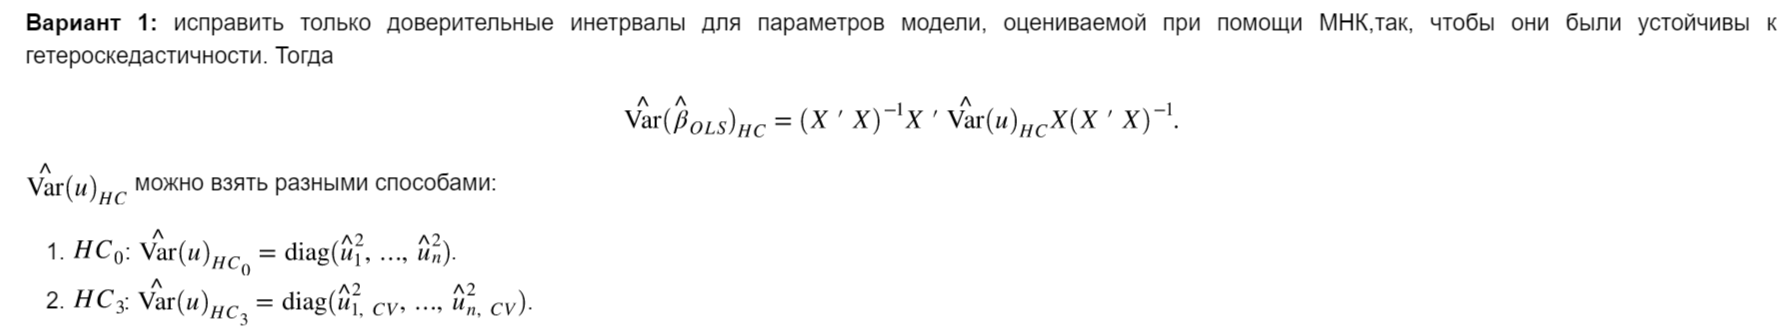

In [29]:
model = smf.ols(data=df, formula = 'Temperature ~ Humidity + log_w_speed + log_vis').fit(cov_type = 'HC0')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Temperature   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                 2.766e+04
Date:                Fri, 04 Dec 2020   Prob (F-statistic):               0.00
Time:                        20:17:49   Log-Likelihood:            -3.2602e+05
No. Observations:               96453   AIC:                         6.520e+05
Df Residuals:                   96449   BIC:                         6.521e+05
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      29.2521      0.205    143.035      

Как мы можем видеть, значимость коэффициентов не изменилась

**Пункт 7.** Проведите какой-нибудь тест для идентификации эндогенности. Если эндогенность обнаружена, скорректируйте её каким-нибудь способом.

Причины эндогенности:

1. Пропущенные переменные
2. Ошибки измерения

Как проявляется на практике:

1. $E(u_i | x) \ne 0$
2. $cov(x_i^j, u_i) \ne 0$

Мы знаем, что пункт 1 является одной из предпосылок теоремы Гаусса-Маркова. Также из семинара 11 знаем, что при нарушении этого условия оценки, полученные методом МНК перестают быть состоятельными. Таким образом попробуем проверить состоятельность оценок, тем самым поймем, нарушено ли условие ТГМ: $E(u_i | x) \ne 0$, а значит присутсвует ли эндогенность.

Да, это все замечательно и правда, но проверить оценки на состоятельность в Питоне мы не можем, так  что проведем статистический тест Хаусмана

In [30]:
from statsmodels.sandbox.regression.gmm import IV2SLS  

In [31]:
result = IV2SLS(model.model.endog, model.model.exog, instrument=df['Apparent_Temperature']).fit()
result.spec_hausman()

(-19368582.12268326, 1.0, 4)

Как можно заметить, pvalue = 1,  значит гипотеза на уровне значимости 5% об отсутствии эндогенности не отвергается. Значит эндогенность в данных не выявлена.

**Пункт 8.** Если после проведённых корректировок интерпретация каких-либо параметров модели изменилась, приведите новую интерпретацию. Сделайте финальный вывод о том, какие факторы влияют на температуру воздуха.

Интерпретация параметров не изменилась, так что выводы о влиянии выбранных нами факторов на температуру остаеются такими же.  В моем случае на тепературу влияют все 3 выбранных мною призака - владность, логарифм скорости ветра и логарифм видимости.

**Построение предиктивной модели.**

In [32]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

Воспользуйтесь вашими знаниями из машинного обучения и постройте хорошую предиктивную линейную регрессионную модель для предсказания температуры воздуха. Используйте MAE для выбора лучшей модели. 

In [108]:
df.corr()

,Summary,Precip_Type,Temperature,Apparent_Temperature,Humidity,Wind_Speed,Wind_Bearing,Visibility,Pressure,Daily_Summary,year,month,day,w_speed_2,log_w_speed,humidity_2,log_humidity,vis_2,log_vis,log_t
Summary,1.000000,-0.106454,0.146658,0.142760,-0.113119,0.004258,0.022789,0.140138,0.143405,0.157569,0.055975,-0.030341,-0.016680,-0.074019,0.074910,-0.121538,-0.108891,0.076600,0.209656,0.096728
Precip_Type,-0.106454,1.000000,-0.542245,-0.545264,0.223896,-0.068319,-0.040390,-0.291999,0.006472,-0.235579,-0.065065,-0.151520,0.000498,-0.051097,-0.073707,0.233648,0.218237,-0.244180,-0.300166,0.007799
Temperature,0.146658,-0.542245,1.000000,0.992629,-0.632255,0.008957,0.029988,0.392847,-0.005447,0.438879,0.017462,0.148576,-0.000802,-0.012053,0.028707,-0.617598,-0.633835,0.324620,0.411523,0.841948
Apparent_Temperature,0.142760,-0.545264,0.992629,1.000000,-0.602571,-0.056650,0.029031,0.381718,-0.000219,0.433791,0.017171,0.157986,0.001743,-0.066861,-0.037818,-0.589049,-0.603786,0.318394,0.395759,0.854255
Humidity,-0.113119,0.223896,-0.632255,-0.602571,1.000000,-0.224951,0.000735,-0.369173,0.005454,-0.368180,0.039257,0.056526,0.004851,-0.187813,-0.224764,0.989105,0.998076,-0.289764,-0.399660,-0.475724
Wind_Speed,0.004258,-0.068319,0.008957,-0.056650,-0.224951,1.000000,0.103822,0.100749,-0.049263,-0.004115,-0.004245,-0.098905,-0.006659,0.936325,0.907682,-0.241460,-0.216753,0.050650,0.141105,-0.029963
Wind_Bearing,0.022789,-0.040390,0.029988,0.029031,0.000735,0.103822,1.000000,0.047594,-0.011651,0.053709,-0.025685,-0.019208,-0.003490,0.096238,0.126208,-0.000108,0.001012,0.035194,0.055538,0.011147
Visibility,0.140138,-0.291999,0.392847,0.381718,-0.369173,0.100749,0.047594,1.000000,0.059818,0.457913,0.107306,-0.071946,-0.026374,0.079744,0.106640,-0.417818,-0.347470,0.964171,0.933350,0.325942
Pressure,0.143405,0.006472,-0.005447,-0.000219,0.005454,-0.049263,-0.011651,0.059818,1.000000,0.054305,0.016124,-0.019308,-0.015452,-0.049159,-0.039540,0.007337,0.004610,0.062634,0.060440,-0.004505
Daily_Summary,0.157569,-0.235579,0.438879,0.433791,-0.368180,-0.004115,0.053709,0.457913,0.054305,1.000000,-0.023285,-0.009223,-0.016664,-0.020763,0.013168,-0.382073,-0.360169,0.400171,0.464826,0.343767


Для самого начала посчитаем прогноз нашей объясняющей модели, чтобы не получилось так, что она предсказывает лучше предиктивной... А то я тот еще машинообучатель, конечно...

In [33]:
X = df[['Humidity', 'log_w_speed', 'log_vis']]
y = df['Temperature']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

mod = LinearRegression()
mod.fit(X_train, y_train)
y_pred = mod.predict(X_test)

print("Значение MAE = для объясняющей модели %.4f" % mean_absolute_error(y_test, y_pred))

Значение MAE = для объясняющей модели 5.7480


Теперь посчитаем ошибку для наилучшего константного прогноза, чтобы понимать, насколько мы плохи...

In [35]:
best_constant = df['Temperature'].median()  #для mae лучший константный прогноз - медиана
print("Значение MAE при наилучшем константном приближении = %.4f" % mean_absolute_error(df['Temperature'], best_constant * np.ones(df['Temperature'].shape)))

Значение MAE при наилучшем константном приближении = 7.9158


Как мы можем видеть, качество прогноза нашей объясняющей модели не сильно лучше наилучшего константного прогноза

Хочу выделить странный признак, отвечающий за то, какое время года на дворе (кажется, что он будет немного лучше месяца)

In [36]:
df['season'] = 0
df.loc[((df['month'] == 12) | (df['month'] == 1) | (df['month'] == 2)), 'season'] = 0  #зима
df.loc[((df['month'] == 3) | (df['month'] == 4) | (df['month'] == 5)), 'season'] = 1  #весна
df.loc[((df['month'] == 6) | (df['month'] == 7) | (df['month'] == 8)), 'season'] = 2  #лето
df.loc[((df['month'] == 9) | (df['month'] == 10) | (df['month'] == 11)), 'season'] = 3  #осень

Теперь посмотрим, имеются ли в данных выбросы (для признаков, для которы- это можно понять вообще)

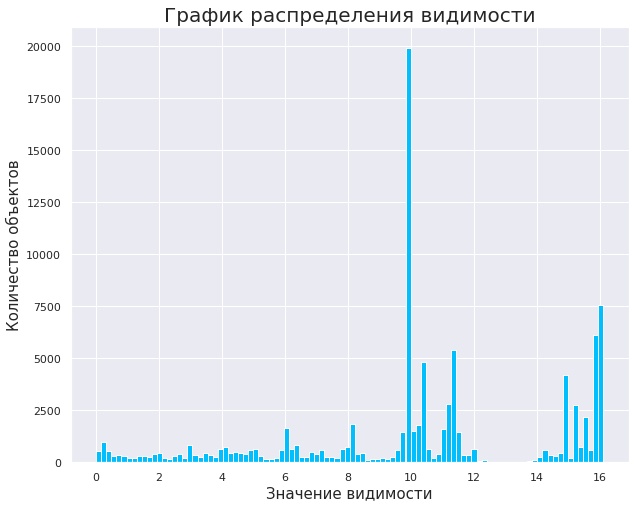

In [158]:
plt.figure(figsize=(10, 8))
plt.hist(df['Visibility'], bins=100, color='deepskyblue')
plt.xlabel('Значение видимости', size=15)
plt.ylabel('Количество объектов', size=15)
plt.title('График распределения видимости', size=20)
plt.show()

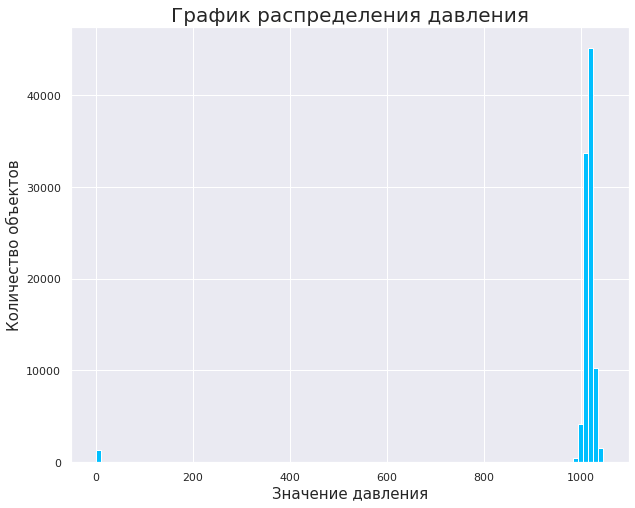

In [159]:
plt.figure(figsize=(10, 8))
plt.hist(df['Pressure'], bins=100, color='deepskyblue')
plt.xlabel('Значение давления', size=15)
plt.ylabel('Количество объектов', size=15)
plt.title('График распределения давления', size=20)
plt.show()

Ага, вот и засланый казачок! Очевидно, что давлление не может иметь значение 0. Так что это какой-то странный выброс.

In [166]:
df.loc[df['Pressure'] == 0].shape[0]

1288

Кажется, что это очень много данных, но у нас довольно большая выборка. Так что можем удалить все объекты с нулевым значением давления.

In [38]:
df = df.loc[df['Pressure'] > 0]

Продолжаем

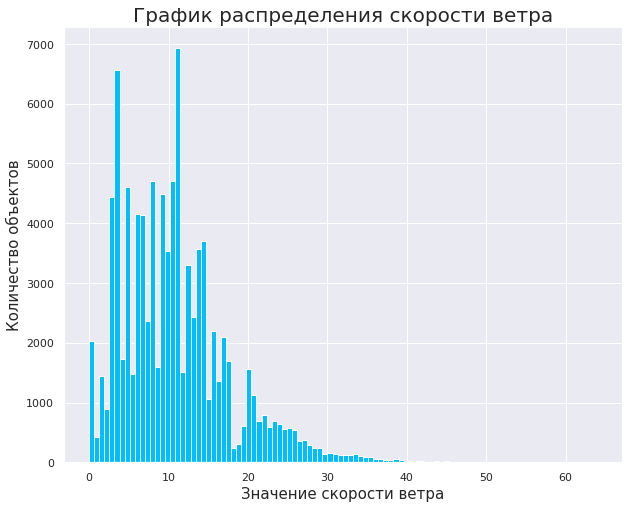

In [168]:
plt.figure(figsize=(10, 8))
plt.hist(df['Wind_Speed'], bins=100, color='deepskyblue')
plt.xlabel('Значение скорости ветра', size=15)
plt.ylabel('Количество объектов', size=15)
plt.title('График распределения скорости ветра', size=20)
plt.show()

Ладно, в целом скорость ветра може быть 60 км/ч, не будем считать это выбросом

Кажется, что в остальных признаках выбросов не наблюдается

In [169]:
df


,Formatted Date,Summary,Precip_Type,Temperature,Apparent_Temperature,Humidity,Wind_Speed,Wind_Bearing,Visibility,Pressure,Daily_Summary,year,month,day,log_t,w_speed_2,log_w_speed,humidity_2,log_humidity,vis_2,log_vis,season
0,2006-03-31 22:00:00+00:00,19,1,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,197,2006,3,31,2.248364,199.365928,2.715999,0.7921,0.636577,250.471772,2.822943,1
1,2006-03-31 23:00:00+00:00,19,1,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,197,2006,3,31,2.235970,203.478813,2.725536,0.7396,0.620576,250.471772,2.822943,1
2,2006-04-01 00:00:00+00:00,17,1,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,197,2006,4,1,2.238343,15.432327,1.595014,0.7921,0.636577,223.708858,2.769891,1
3,2006-04-01 01:00:00+00:00,19,1,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,197,2006,4,1,2.114916,198.911533,2.714933,0.6889,0.604316,250.471772,2.822943,1
4,2006-04-01 02:00:00+00:00,17,1,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,197,2006,4,1,2.169688,121.983189,2.488616,0.6889,0.604316,250.471772,2.822943,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96448,2016-09-09 17:00:00+00:00,19,1,26.016667,26.016667,0.43,10.9963,31.0,16.1000,1014.36,170,2016,9,9,3.258737,120.918614,2.484598,0.1849,0.357674,259.210000,2.839078,3
96449,2016-09-09 18:00:00+00:00,19,1,24.583333,24.583333,0.48,10.0947,20.0,15.5526,1015.16,170,2016,9,9,3.202069,101.902968,2.406468,0.2304,0.392042,241.883367,2.806543,3
96450,2016-09-09 19:00:00+00:00,19,1,22.038889,22.038889,0.56,8.9838,30.0,16.1000,1015.66,170,2016,9,9,3.092809,80.708662,2.300964,0.3136,0.444686,259.210000,2.839078,3
96451,2016-09-09 20:00:00+00:00,19,1,21.522222,21.522222,0.60,10.5294,20.0,16.1000,1015.95,170,2016,9,9,3.069086,110.868264,2.444900,0.3600,0.470004,259.210000,2.839078,3


Напомню, что мы уже раньше применили LabelEncoder, значит сейчас можем спокойно строить линейную регрессию (ну или не очень спокойно, как пойдет)


In [39]:
X = df[['Apparent_Temperature', 'Precip_Type', 'Humidity', 'Visibility', 'Wind_Speed', 'Wind_Bearing', 'Pressure','month', 'Daily_Summary', 'Summary', 'season', 'year', 'day', 'log_w_speed', 'log_humidity', 'w_speed_2', 'humidity_2', 'log_vis']]
y = df['Temperature']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

mod = LinearRegression()
mod.fit(X_train, y_train)
y_pred = mod.predict(X_test)

print("Значение MAE = %.4f" % mean_absolute_error(y_test, y_pred))

Значение MAE = 0.7062


Как можно заметить, модель уже в разы лучше наилучшего константного прогноза. И вроде бы все супер! Но есть одна проблемка... Оставлять apparent temperature - совсем плохая идея, так как данная переменна содержит слишком много информации о таргете и слишком сильно с ним коррелирует. Так что уберем ее

In [40]:
X = df[['Precip_Type', 'Humidity', 'Visibility', 'Pressure','month',  'Wind_Speed', 'Wind_Bearing', 'Daily_Summary', 'Summary', 'season', 'year', 'day', 'log_w_speed', 'log_humidity', 'w_speed_2', 'humidity_2', 'log_vis']]
y = df['Temperature']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

mod = LinearRegression()
mod.fit(X_train, y_train)
y_pred = mod.predict(X_test)

print("Значение MAE = %.4f" % mean_absolute_error(y_test, y_pred))

Значение MAE = 4.0646


Нуууу, не лучшее MAE в мире, да, но вот так вот вышло... В целом, это на 1,5 меньше нашей объясняющей модели и почти в 2 раза лучше константного прогноза

**Сравнение объясняющей и предиктивной моделей.**

**Пункт 1.** Является ли предиктивная модель значимой в целом? Что можно сказать о значимости отдельных коэффициентов? 

In [41]:
model_p = smf.ols(data=df, formula = 'Temperature ~ Precip_Type + Humidity + Visibility + month + Daily_Summary + Wind_Speed + Wind_Bearing + Summary + year + day + season + log_w_speed + log_humidity + w_speed_2 + humidity_2 + log_vis').fit()
print(model_p.summary())

                            OLS Regression Results                            
Dep. Variable:            Temperature   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                 1.247e+04
Date:                Fri, 04 Dec 2020   Prob (F-statistic):               0.00
Time:                        20:18:42   Log-Likelihood:            -2.9595e+05
No. Observations:               95165   AIC:                         5.919e+05
Df Residuals:                   95148   BIC:                         5.921e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -15.5447     11.575     -1.343

Как мы можем видеть по значению F статистики и t статистик для отдельных коэффициентов, предиктивная модель значима в целом, а также все ее коэффициенты, кроме коэффициента при признаках "day", 'w_speed_2' также вышли значимыми (pvalue < 0.05). У "day", 'w_speed_2' же pvalue > 0.05, значит гипотеза о незначимости признака не отвергается.

**Пункт 2.** Как различаются регрессоры объясняющей и предиктивной моделей? Есть ли такие регрессоры, которые вошли в одну, но не вошли в другую. Если да, приведите возможную содержательную интерпретацию этого явления.

В моем случае общими для обеих моделей стали только признаки 'Humidity', 'log_w_speed', 'log_vis'. В целом признаки для моделей отличаются потому что некоторые признаки хороши для построения прогнозов, но при этом не сильно несут в себе какой-то логический смысл, поэтому я их и не включала в объясняющую модель. В целом, вышло так, что в предиктивную модель вошли почти все признаки. В общем все признаки из объясняющей модели скорее всего могутвходить в предиктивную, но в обратную сторону это не работает. Не обязательно, если признак помогает при прогнозировании, то он несет в себе какой-то объясняющий таргет смысл.

**Пункт 3.** На основе предыдущего анализа, сделайте вывод, можно ли использовать объясняющую модель для предсказания, а предиктивную -- для объяснений. Если да, то сравните предсказательную и объяснительную силу этих моделей на основе каких-нибудь метрик.

Предсказательную силу моделей уже сравнила выше, метрикой MAE. Объясняющую модель для предсказания использовать, конечно, можно, кто там запретит. Но качество предскзания в таком случае будет, очевидно, ниже, чем у предиктивной. А вот предиктиную для объяснения можно использовать уже значительно реже. Бывает, коненчо, что хорошая предиктивная модель является и объяснительной, но зачастую предиктивные модели не очень хорошо объясняют дисперсию таргета, а иногда могут быть незначимыми в целом. Сравним объяснительную силу наших двух моделей. При помощи $R^2$, чем ближе $R^2$ к единице, тем лучше модель объясняет дисперсию таргета.

In [43]:
X_d = df[['Humidity', 'log_w_speed', 'log_vis']]
y_d = df['Temperature']
X_pr = df[['Precip_Type', 'Humidity', 'Visibility', 'Pressure','month',  'Wind_Speed', 'Wind_Bearing', 'Daily_Summary', 'Summary', 'season', 'year', 'day', 'log_w_speed', 'log_humidity', 'w_speed_2', 'humidity_2', 'log_vis']]
y_pr = df['Temperature']

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.8, random_state=42)
X_train_pr, X_test_pr, y_train_pr, y_test_pr = train_test_split(X_pr, y_pr, test_size=0.8, random_state=42)

mod_d = LinearRegression()
mod_d.fit(X_train_d, y_train_d)
y_pred_d = mod_d.predict(X_test_d)

mod_pr = LinearRegression()
mod_pr.fit(X_train_pr, y_train_pr)
y_pred_pr = mod_pr.predict(X_test_pr)

print('Значение R^2 для объясняющей модели =', r2_score(y_test_d, y_pred_d))
print('Значение R^2 для предиктивной модели =', r2_score(y_test_pr, y_pred_pr))

Значение R^2 для объясняющей модели = 0.4455964094766829
Значение R^2 для предиктивной модели = 0.7172658815254616


Оу, в нашем случае вышло, что предиктивная моедль лучше объясняет дисперсию таргета, чем объясняющая. И такое тоже бывает. В данном случае так очвеидно вышло потому, что в предиктивную модель включены почти все возможные признаки, а в объясняющую всего 3. Конечно, могло быть так, что значение $R^2$ для предиктивное модели бы было куда хуже. Такое часто бывает, если объясняющая модель и предиктивная примерно схожи по сложности (подробности или как это правильно назвать). То есть если бы в данном случае объясняющая модель бы содержала много признаков или предиктивная меньше, то картина была бы иной. Но я решила показать имненно такую картину. И решила, что лучше в объясняющую модель включить меньше признаков, но влияние которых на таргет действительно можно логически объяснить. 